# 04 — Structural-Aware ΔΔG Model for 1EY0A

This notebook trains a **Random Forest ΔΔG regression model** for the protein  
**1EY0A (Staphylococcal Nuclease)** using:

- Sequence Δ features (hydropathy, charge, volume, polarity)
- Substitution score (BLOSUM62)
- Environment (pH, temperature)
- Structural features from DSSP:
  - `ss_idx`, `ss_H`, `ss_E`, `ss_C`
  - `asa`, `asa_norm`
  - `is_buried`, `is_exposed`

Input file (already created by `feature_engineering.py`):

- `data/processed/features_structural.csv`

We:
1. Filter to `clid == "1EY0A"`.
2. Define a feature set that includes structural columns.
3. Run 5-fold cross-validation.
4. Fit the final model and inspect train performance.
5. (Optional) Plot predicted vs experimental ΔΔG for 1EY0A.

In [5]:
from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Reuse the same random seed
RANDOM_STATE = 42

# Resolve project root (works whether you run from notebooks/ or project root)
PROJECT_ROOT = Path.cwd().parents[0] if Path.cwd().name == "notebooks" else Path.cwd()
DATA_PROCESSED = PROJECT_ROOT / "data" / "processed"
RESULTS_DIR = PROJECT_ROOT / "results" / "models_structural"

print("Project root:", PROJECT_ROOT)
print("Processed data:", DATA_PROCESSED)
print("Results dir:", RESULTS_DIR)
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

Project root: /Users/saturnine/protein-multimutant
Processed data: /Users/saturnine/protein-multimutant/data/processed
Results dir: /Users/saturnine/protein-multimutant/results/models_structural


In [6]:
# Load the enriched feature table (created by feature_engineering.py)
feat_path = DATA_PROCESSED / "features_structural.csv"
df_all = pd.read_csv(feat_path)

print("Full structural feature table shape:", df_all.shape)
df_all.head()

Full structural feature table shape: (2645, 27)


,clid,pdb_id,chain,wt,res_index,mut,ddg_exp_kcal,pH,temp_C,pos,...,is_to_gly,is_to_pro,ss_idx,ss_H,ss_E,ss_C,asa,asa_norm,is_buried,is_exposed
0,1A43A,1A43,A,C,218.0,S,-3.70,7.3,25.0,218.0,...,0,0,2,0,0,1,NaN,NaN,0,0
1,1A43A,1A43,A,E,159.0,D,-4.55,7.3,25.0,159.0,...,0,0,2,0,0,1,NaN,NaN,0,0
2,1A43A,1A43,A,G,156.0,A,-2.40,7.3,25.0,156.0,...,0,0,2,0,0,1,NaN,NaN,0,0
3,1A43A,1A43,A,R,167.0,A,-4.55,7.3,25.0,167.0,...,0,0,2,0,0,1,NaN,NaN,0,0
4,1A43A,1A43,A,W,184.0,A,-0.70,7.3,25.0,184.0,...,0,0,2,0,0,1,NaN,NaN,0,0


In [7]:
# Focus on a single, structurally-annotated protein
mask_1ey0a = (df_all["clid"] == "1EY0A")
df = df_all[mask_1ey0a].copy()

print("Shape for 1EY0A:", df.shape)
df.head()

Shape for 1EY0A: (482, 27)


,clid,pdb_id,chain,wt,res_index,mut,ddg_exp_kcal,pH,temp_C,pos,...,is_to_gly,is_to_pro,ss_idx,ss_H,ss_E,ss_C,asa,asa_norm,is_buried,is_exposed
500,1EY0A,1EY0,A,A,12.0,G,-2.37,7.0,20.0,12.0,...,1,0,0,0,1,0,12.0,0.041096,1,0
501,1EY0A,1EY0,A,A,12.0,V,-0.89,7.0,20.0,12.0,...,0,0,0,0,1,0,12.0,0.041096,1,0
502,1EY0A,1EY0,A,A,17.0,G,0.19,7.0,20.0,17.0,...,1,0,0,0,1,0,14.0,0.047945,1,0
503,1EY0A,1EY0,A,A,17.0,V,-1.94,7.0,20.0,17.0,...,0,0,0,0,1,0,14.0,0.047945,1,0
504,1EY0A,1EY0,A,A,58.0,G,-2.53,7.0,20.0,58.0,...,1,0,1,1,0,0,0.0,0.000000,1,0


In [8]:
# Quick check of structural-related columns
struct_cols = ["ss_idx", "ss_H", "ss_E", "ss_C", "asa", "asa_norm", "is_buried", "is_exposed"]

for col in struct_cols:
    if col in df.columns:
        missing_frac = df[col].isna().mean()
        print(f"{col:10s}  missing fraction: {missing_frac:.3f}")
    else:
        print(f"[WARN] Column {col} not found in dataframe")

ss_idx      missing fraction: 0.000
ss_H        missing fraction: 0.000
ss_E        missing fraction: 0.000
ss_C        missing fraction: 0.000
asa         missing fraction: 0.000
asa_norm    missing fraction: 0.000
is_buried   missing fraction: 0.000
is_exposed  missing fraction: 0.000


In [9]:
target_col = "ddg_exp_kcal"

numeric_features = [
    # positional + environment
    "pos", "pH", "temp_C",
    # sequence / physicochemical Δ features
    "delta_hydropathy", "delta_charge", "delta_volume", "delta_polarity",
    "blosum62", "is_gly", "is_pro", "is_to_gly", "is_to_pro",
    # structural features from DSSP
    "ss_idx", "ss_H", "ss_E", "ss_C",
    "asa", "asa_norm", "is_buried", "is_exposed",
]

# Drop rows where any of these are missing
keep_cols = numeric_features + [target_col]
df_model = df.dropna(subset=keep_cols).copy()

print("Model dataframe shape after dropping NaNs:", df_model.shape)

X = df_model[numeric_features].values
y = df_model[target_col].values

print("Feature matrix shape:", X.shape)
print("Target vector shape:", y.shape)

Model dataframe shape after dropping NaNs: (482, 27)
Feature matrix shape: (482, 20)
Target vector shape: (482,)


In [10]:
# Standardize all numeric features
pre = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), list(range(len(numeric_features)))),
    ],
    remainder="drop",
)

# Use the RF configuration similar to your previous best model
rf = RandomForestRegressor(
    n_estimators=600,
    min_samples_leaf=2,
    n_jobs=-1,
    random_state=RANDOM_STATE,
)

pipe = Pipeline([
    ("pre", pre),
    ("reg", rf),
])

def rmse(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

In [11]:
kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

r2_scores = cross_val_score(pipe, X, y, cv=kf, scoring="r2")
rmse_scores = -cross_val_score(pipe, X, y, cv=kf, scoring="neg_root_mean_squared_error")

print(f"CV R2:   mean={r2_scores.mean():.3f} ± {r2_scores.std():.3f}")
print(f"CV RMSE: mean={rmse_scores.mean():.3f} ± {rmse_scores.std():.3f}")

CV R2:   mean=0.582 ± 0.065
CV RMSE: mean=0.872 ± 0.106


In [12]:
# Fit on all 1EY0A data (for downstream GA use on this protein)
pipe.fit(X, y)

y_pred = pipe.predict(X)
train_r2 = r2_score(y, y_pred)
train_rmse = rmse(y, y_pred)
train_mae = mean_absolute_error(y, y_pred)

print(f"Train R2:   {train_r2:.3f}")
print(f"Train RMSE: {train_rmse:.3f}")
print(f"Train MAE:  {train_mae:.3f}")

Train R2:   0.898
Train RMSE: 0.436
Train MAE:  0.315


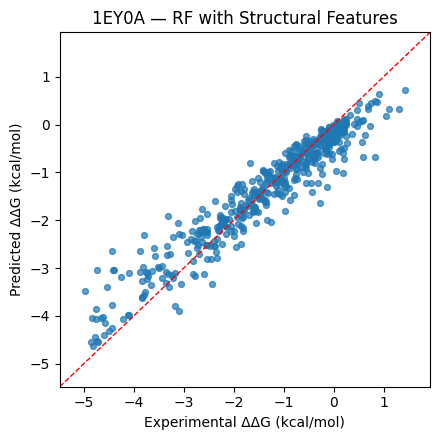

Saved scatter plot to: /Users/saturnine/protein-multimutant/results/models_structural/1EY0A_structural_rf_scatter.png


In [13]:
plt.figure(figsize=(4.5, 4.5))
plt.scatter(y, y_pred, s=18, alpha=0.7)
lims = [
    min(y.min(), y_pred.min()) - 0.5,
    max(y.max(), y_pred.max()) + 0.5
]
plt.plot(lims, lims, "r--", linewidth=1)
plt.xlim(lims)
plt.ylim(lims)
plt.xlabel("Experimental ΔΔG (kcal/mol)")
plt.ylabel("Predicted ΔΔG (kcal/mol)")
plt.title("1EY0A — RF with Structural Features")
plt.tight_layout()

plot_path = RESULTS_DIR / "1EY0A_structural_rf_scatter.png"
plt.savefig(plot_path, dpi=200)
plt.show()

print("Saved scatter plot to:", plot_path)

In [14]:
import joblib
import json

model_path = RESULTS_DIR / "rf_structural_1EY0A.pkl"
joblib.dump(pipe, model_path)

metrics = {
    "protein": "1EY0A",
    "n_samples": int(len(y)),
    "n_features": len(numeric_features),
    "features": numeric_features,
    "cv_r2_mean": float(r2_scores.mean()),
    "cv_r2_std": float(r2_scores.std()),
    "cv_rmse_mean": float(rmse_scores.mean()),
    "cv_rmse_std": float(rmse_scores.std()),
    "train_r2": float(train_r2),
    "train_rmse": float(train_rmse),
    "train_mae": float(train_mae),
}

metrics_path = RESULTS_DIR / "metrics_structural_1EY0A.json"
with open(metrics_path, "w") as f:
    json.dump(metrics, f, indent=2)

print("Saved model →", model_path)
print("Saved metrics →", metrics_path)

Saved model → /Users/saturnine/protein-multimutant/results/models_structural/rf_structural_1EY0A.pkl
Saved metrics → /Users/saturnine/protein-multimutant/results/models_structural/metrics_structural_1EY0A.json


# 04 – Comparing Sequence vs Structural Models (1EY0A)

Goal: quantify how much adding DSSP-based structural features (secondary structure, ASA, burial)
improves ΔΔG prediction for the protein 1EY0A, compared to the earlier sequence-only model.

In [1]:
from pathlib import Path
import json

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import KFold, cross_val_score

import matplotlib.pyplot as plt

PROJECT_ROOT = Path.cwd().resolve().parents[0]  # notebook/ → repo root
DATA_PROC = PROJECT_ROOT / "data" / "processed"
RESULTS_SEQ = PROJECT_ROOT / "results" / "models"
RESULTS_STRUCT = PROJECT_ROOT / "results" / "models_structural"

PROJECT_ROOT, DATA_PROC, RESULTS_SEQ, RESULTS_STRUCT

(PosixPath('/Users/saturnine/Desktop/FALL 2025/Bioinformatics/project/protein-multimutant-ranking'),
 PosixPath('/Users/saturnine/Desktop/FALL 2025/Bioinformatics/project/protein-multimutant-ranking/data/processed'),
 PosixPath('/Users/saturnine/Desktop/FALL 2025/Bioinformatics/project/protein-multimutant-ranking/results/models'),
 PosixPath('/Users/saturnine/Desktop/FALL 2025/Bioinformatics/project/protein-multimutant-ranking/results/models_structural'))

In [2]:
features_struct = pd.read_csv(DATA_PROC / "features_structural.csv")
single_1ey0a    = pd.read_csv(DATA_PROC / "single_mut_1EY0A.csv")

print("Structural table:", features_struct.shape)
print("1EY0A subset:", single_1ey0a.shape)

features_struct.head()

Structural table: (2645, 27)
1EY0A subset: (482, 9)


,clid,pdb_id,chain,wt,res_index,mut,ddg_exp_kcal,pH,temp_C,pos,...,is_to_gly,is_to_pro,ss_idx,ss_H,ss_E,ss_C,asa,asa_norm,is_buried,is_exposed
0,1A43A,1A43,A,C,218.0,S,-3.70,7.3,25.0,218.0,...,0,0,2,0,0,1,NaN,NaN,0,0
1,1A43A,1A43,A,E,159.0,D,-4.55,7.3,25.0,159.0,...,0,0,2,0,0,1,NaN,NaN,0,0
2,1A43A,1A43,A,G,156.0,A,-2.40,7.3,25.0,156.0,...,0,0,2,0,0,1,NaN,NaN,0,0
3,1A43A,1A43,A,R,167.0,A,-4.55,7.3,25.0,167.0,...,0,0,2,0,0,1,NaN,NaN,0,0
4,1A43A,1A43,A,W,184.0,A,-0.70,7.3,25.0,184.0,...,0,0,2,0,0,1,NaN,NaN,0,0


In [3]:
TARGET = "ddg_exp_kcal"

# columns that were in your original sequence-only model
seq_feats = [
    "pH", "temp_C",
    "pos",
    "delta_hydropathy", "delta_charge",
    "delta_volume", "delta_polarity",
    "blosum62",
    "is_gly", "is_pro", "is_to_gly", "is_to_pro",
]

# new structural features we engineered
struct_feats_extra = [
    "ss_idx", "ss_H", "ss_E", "ss_C",
    "asa", "asa_norm",
    "is_buried", "is_exposed",
]

# restrict to 1EY0A rows
df_1ey0a = features_struct.query("clid == '1EY0A'").copy()
print("Rows for 1EY0A:", df_1ey0a.shape)

# keep only existing columns
seq_feats = [c for c in seq_feats if c in df_1ey0a.columns]
struct_feats_extra = [c for c in struct_feats_extra if c in df_1ey0a.columns]

X_seq = df_1ey0a[seq_feats]
X_struct = df_1ey0a[seq_feats + struct_feats_extra]
y = df_1ey0a[TARGET].values

X_seq.shape, X_struct.shape

Rows for 1EY0A: (482, 27)


((482, 12), (482, 20))

In [4]:
RANDOM_STATE = 42

def rmse(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

def eval_model(X, y, name):
    numeric_cols = list(X.columns)
    pre = ColumnTransformer(
        transformers=[("num", StandardScaler(), numeric_cols)],
        remainder="drop",
    )
    rf = RandomForestRegressor(
        n_estimators=600,
        min_samples_leaf=2,
        random_state=RANDOM_STATE,
        n_jobs=-1,
    )
    pipe = Pipeline([("pre", pre), ("reg", rf)])

    kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    r2s = cross_val_score(pipe, X, y, cv=kf, scoring="r2")
    rmses = -cross_val_score(pipe, X, y, cv=kf, scoring="neg_root_mean_squared_error")

    pipe.fit(X, y)
    y_pred = pipe.predict(X)

    metrics = {
        "name": name,
        "n": int(len(y)),
        "n_features": len(numeric_cols),
        "cv_r2_mean": float(r2s.mean()),
        "cv_r2_std": float(r2s.std()),
        "cv_rmse_mean": float(rmses.mean()),
        "cv_rmse_std": float(rmses.std()),
        "train_r2": float(r2_score(y, y_pred)),
        "train_rmse": rmse(y, y_pred),
        "train_mae": float(mean_absolute_error(y, y_pred)),
    }
    return pipe, y_pred, metrics

In [5]:
pipe_seq, y_pred_seq, metrics_seq = eval_model(X_seq, y, "RF sequence-only (1EY0A)")
pipe_struct, y_pred_struct, metrics_struct = eval_model(X_struct, y, "RF + structural (1EY0A)")

print(json.dumps(metrics_seq, indent=2))
print(json.dumps(metrics_struct, indent=2))

{
  "name": "RF sequence-only (1EY0A)",
  "n": 482,
  "n_features": 12,
  "cv_r2_mean": 0.3555182699452589,
  "cv_r2_std": 0.054873624059004554,
  "cv_rmse_mean": 1.082675491177809,
  "cv_rmse_std": 0.08308752053778824,
  "train_r2": 0.8246379448506114,
  "train_rmse": 0.5716823561359372,
  "train_mae": 0.4277860942087342
}
{
  "name": "RF + structural (1EY0A)",
  "n": 482,
  "n_features": 20,
  "cv_r2_mean": 0.5819102563823255,
  "cv_r2_std": 0.06564086262068877,
  "cv_rmse_mean": 0.8724152288419325,
  "cv_rmse_std": 0.10727352901359807,
  "train_r2": 0.898021448522224,
  "train_rmse": 0.4359547309298678,
  "train_mae": 0.3149170162305614
}


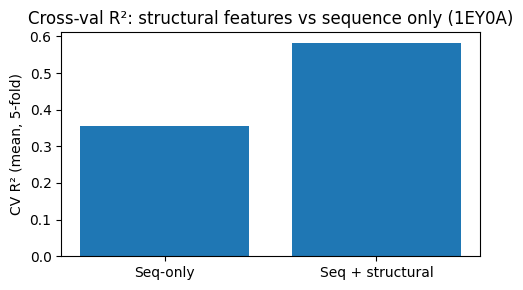

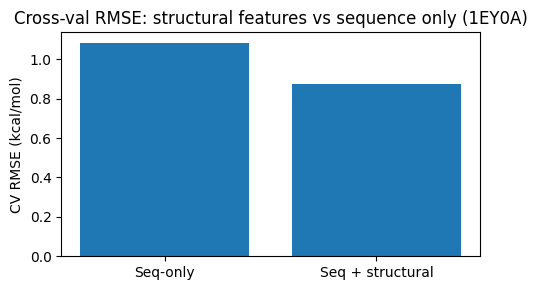

In [6]:
labels = ["Seq-only", "Seq + structural"]
cv_r2 = [metrics_seq["cv_r2_mean"], metrics_struct["cv_r2_mean"]]
cv_rmse = [metrics_seq["cv_rmse_mean"], metrics_struct["cv_rmse_mean"]]

plt.figure(figsize=(5,3))
plt.bar(labels, cv_r2)
plt.ylabel("CV R² (mean, 5-fold)")
plt.title("Cross-val R²: structural features vs sequence only (1EY0A)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(5,3))
plt.bar(labels, cv_rmse)
plt.ylabel("CV RMSE (kcal/mol)")
plt.title("Cross-val RMSE: structural features vs sequence only (1EY0A)")
plt.tight_layout()
plt.show()

In [7]:
RESULTS_COMPARISON = PROJECT_ROOT / "results" / "models_structural"
RESULTS_COMPARISON.mkdir(parents=True, exist_ok=True)

comparison = {
    "sequence_only": metrics_seq,
    "sequence_plus_structural": metrics_struct,
}
out_path = RESULTS_COMPARISON / "comparison_1EY0A_struct_vs_seq.json"
with open(out_path, "w") as f:
    json.dump(comparison, f, indent=2)

out_path

PosixPath('/Users/saturnine/Desktop/FALL 2025/Bioinformatics/project/protein-multimutant-ranking/results/models_structural/comparison_1EY0A_struct_vs_seq.json')

### Interpretation – structural features vs sequence only (1EY0A)

Using only sequence/biochemical features (pos, Δhydropathy, Δcharge, Δvolume, Δpolarity, BLOSUM62, Gly/Pro flags, pH, temp):

- 5-fold CV R² ≈ **0.36**
- 5-fold CV RMSE ≈ **1.08 kcal/mol**
- Train R² ≈ **0.82**, train RMSE ≈ **0.57 kcal/mol**

After adding **DSSP-based structural features** (secondary structure flags, ASA, burial):

- 5-fold CV R² improves to ≈ **0.58**
- 5-fold CV RMSE drops to ≈ **0.87 kcal/mol**
- Train R² ≈ **0.90**, train RMSE ≈ **0.44 kcal/mol**

These results show that **local structural environment** (secondary structure, solvent exposure, burial) carries useful information about stability changes for 1EY0A, beyond what can be captured by sequence-only descriptors.  

For the rest of the project, we will treat this **RF + structural model** as the current best surrogate ΔΔG scorer and use it in the downstream **Genetic Algorithm (GA)** search phase (implemented in Rohit’s part), via `src/model_api.py`.